<a href="https://colab.research.google.com/github/feapri/forecast/blob/master/colab_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install arviz

In [0]:
# import the required libraries
import scipy
import numpy as np
import pandas as pd
import pandas_profiling
import sklearn
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageDraw, ImageFont
import io
from contextlib import redirect_stdout
from IPython.display import Image

import pymc3 as pm
import seaborn as sns
from theano import shared
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import arviz as az
from matplotlib import cbook

%matplotlib inline


# Story Telling
This book is to assist on presenting the findings inside a data sample provided.   For the courious minds, you can see what is behind the scenes by reviewing the main notebook on this directory (main.ipynb)

### How to use it?

You can go cells by cell reading the content and associating the readings to the charts presented.    Altough you can skip and go to a particular it's recommended to go in the sequencial order presented to acquire the overal picture. then you can go back and forth as you wish.   

### Can this book be reused?
You can provide a new dataset and follow the steps below to obtain the view of the new dataset:   
- Load the file with the new data on the same directory as this file.
- Open the `main.ipynb` book and run all the cells in it.
    - a new set of charts will be generated
    - a set of test will be ran on the data.
- Close this book and re-open it.
- When reopened, this book will refresh with the new charts.
- The comments on this book are applicable to the current dataset, for the new dataset the comments need to be revisited to validate them against the new charts and the new tests made. (in other words, the charts are automatically generated but the comments need to be reviewed for new dataset)
- Save this file to keep the comments made based on the new dataset.

## What is the problem at hand?
A given set of data is provided and the goals are:
- to determine the type of data and how is its broken down
- identify if the data is normally distributed
- forecast the expected values until the end of 2021.

Let's start...   on the top menu select `Kernel` and then `Restart and Run All Cells`   
![](./nb_menu_icons.png)

# Understanding the data
Methodology:
Discover the contents of the information provied and using python and packages like pandas, sklearn, seaborn and others identify the best way to predict the future values.

In [19]:
import os
os.mkdir('./tmp', mode=777)
os.mkdir('./output', mode=777)
os.getcwd()

FileExistsError: ignored

In [20]:
# load the data, set the index to the 'date' column and parse the dates in the data file.
df = pd.read_csv('https://raw.githubusercontent.com/feapri/forecast/master/data/input%20data.csv', index_col='date', parse_dates=True) 
s1 = ("The data sample provided contains {} records\r\n".format(str(df.shape[0])))

# Consolidating
df.drop(['Month', 'Year'], axis=1, inplace=True)
df.columns = ['Value', 'Status', 'Branch'] # rename the columns (help avoid errors later on)
df = df.groupby(['date', 'Status', 'Branch'])['Value'].sum() # Consolidate the information
df = df.reset_index()
x = df.iloc[[0,-2]]
print("After consolidation we have {} records with the following structure:\r\n{}\r\n".format(str(df.shape[0]), x))

# df per Branch
dfBranch = df.groupby(['date', 'Branch'])['Value'].sum() # Consolidate the information
dfBranch.iloc[[0,1]]
dfBranch = dfBranch.reset_index()
dfBranch.to_csv('./tmp/' + 'dfBranch' + '.csv', index=False) #save the df to a csv file

#print(str(dfBranch.shape))

# df per Status
dfStatus = df.groupby(['date', 'Status'])['Value'].sum() # Consolidate the information
dfStatus = dfStatus.reset_index()
dfStatus.to_csv('./tmp/' + 'dfStatus' + '.csv', index=False) #save the df to a csv file

#dfStatus.iloc[[0,1]]
#print(str(dfStatus.shape))

After consolidation we have 515 records with the following structure:
          date Status Branch  Value
0   2015-09-01      C    FR1     70
513 2019-06-01      C    FR1    310



### Data contents

In [21]:
listStatus = df['Status'].unique().tolist() # Ientify unique items in the Status column
listBranch = df['Branch'].unique().tolist() # Ientify unique items in the Branch column
months = int(round((df['date'].max() - df['date'].min())/np.timedelta64(1, 'M'), 0)) + 1

s1=""
s1 = ("Summary of the data contents:\r\n")
s1 = s1 + ("\tStatus codes ({}):\t{}\r\n".format(len(listStatus), str(listStatus)[1:-1]))
s1 = s1 + ("\tBranch names ({}):\t{}:\t\r\n".format(len(listBranch) ,str(listBranch)[1:-1]))
s1 = s1 + ("\tStart date:\t\t" + str(df['date'].min()) + "\r\n")
s1 = s1 + ("\tEnd date:\t\t" + str(df['date'].max()) + "\r\n")
s1 = s1 + ("\tMonths in the data:\t{}\r\n".format(months))
s1 = s1 + ("\tExpected records:\t{}\r\n".format(months * len(listStatus) * len(listBranch)))
s1 = s1 + ("\tConsolidated records:\t{}\r\n".format(df.shape[0]))

print(s1)

Summary of the data contents:
	Status codes (3):	'C', 'UE', 'EE'
	Branch names (5):	'FR1', 'IT2', 'SP3', 'GE4', 'HK5':	
	Start date:		2015-09-01 00:00:00
	End date:		2019-06-01 00:00:00
	Months in the data:	46
	Expected records:	690
	Consolidated records:	515



In [0]:
# Generating profile reports.... Preparing information for next steps
# set the index to the 'date' column and parse the dates in the data file.
prodf = pandas_profiling.ProfileReport(df)
prodf.to_file('./output/prodf.html')
df.to_csv('./tmp/' + 'df' + '.csv', index=False) #save the df to a csv file

# consolidate all Status codes per branch per month
dfSumm = df.copy(deep=True)
dfSumm['Value'] = dfSumm['Value'].groupby(dfSumm['date']).transform('sum')  
dfSumm.drop(['Status', 'Branch'], axis=1, inplace=True)
dfSumm = dfSumm.drop_duplicates(keep="first")
#dfSumm = dfSumm.set_index(['date'])
prodfSumm = pandas_profiling.ProfileReport(dfSumm) # Generate the seasonal_decompose profile report
prodfSumm.to_file('./output/prodfSumm.html') # save the profile report to file
dfSumm.to_csv('./tmp/' + 'dfSumm' + '.csv', index=False) #save the df to a csv file

dictdf ={'df':df, 'prodf':prodf, 'dfSumm':dfSumm, 'prodfSumm':prodfSumm}

base = "df"
listdfM = ['df',]
listdfS = ['dfSumm',]
listdecompM = ['prodf']
listdecompS = ['prodfSumm']

for i in listBranch:
    listdfM.append(base + i)
    mask = ((df['Branch'] == i)) # Mask to filter the df
    dfname = df.loc[mask] # filters the df to keep only the items of interest
    listdecompM.append('pro' + base + i)
    decomp = pandas_profiling.ProfileReport(dfname) # Generate the seasonal_decompose profile report
    decomp.to_file('./output/pro' + base + i + '.html') # save the profile report to file
    dfname.to_csv('./tmp/' + base + i + '.csv', index=False) #save the df to a csv file

    dictdf[base + i] = dfname
    dictdf['pro' + base + i] = decomp
    
    # consolidate all Status codes per branch
    listdfS.append(base + i + 'Summ')
    dfname2 = dfname.copy(deep=True)
    dfname2['Value'] = dfname2['Value'].groupby(dfname2['date']).transform('sum')  
    dfname2.drop(['Status', 'Branch'], axis=1, inplace=True)
    dfname2 = dfname2.drop_duplicates(keep="first")
#    dfname2 = dfname2.set_index(['date'])   
    listdecompS.append('pro' + base + i + 'Summ')
    decomp2 = pandas_profiling.ProfileReport(dfname) # Generate the seasonal_decompose profile report
    decomp2.to_file('./output/pro' + base + i + 'Summ.html') # save the profile report to file
    dfname2.to_csv('./tmp/' + base + i + 'Summ.csv', index=False) #save the df to a csv file

    dictdf[base + i + 'Summ'] = dfname2
    dictdf['pro' + base + i + 'Summ'] = decomp
#    print("Profile Processed for {}\t{}".format(i, str(dfname2.shape)))

# How does the data look like?

Initial view of the data


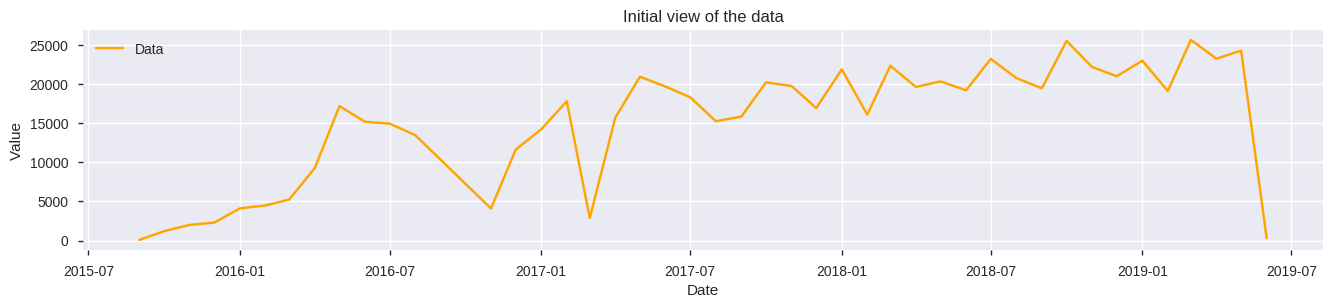

In [23]:
print("Initial view of the data")
#Define chart parms
nrows, ncols = 1, 4
dx, dy = 7, 5 # used for chart sizes
figsize = plt.figaspect(float(dy * nrows) / float(dx * ncols))

Forecast_Months = 31
fig, ax1 = plt.subplots(figsize=figsize)
ax1.plot(dfSumm.set_index('date'), color='orange', label = 'l1')
ax1.set_title("Initial view of the data")
ax1.set_ylabel('Value')
ax1.set_xlabel('Date')

L = ax1.legend() #get the legend
L.get_texts()[0].set_text('Data') #change the legend text for 1st plot
plt.savefig("./output/01Initial view of the data.png")

- Clearly the first and last points in the chart are outliers with some others in the middle

- Following are some of the potential outliers 

In [24]:
# smallest values
x = dfSumm.set_index('date').nsmallest(5, 'Value')
x.reset_index(inplace=True)
x.sort_values(by='date', ascending=True, inplace=True)
x.set_index('date', inplace=True)
x.columns = ['Smallest values']

# largest values
y = dfSumm.set_index('date').nlargest(5, 'Value')
y.reset_index(inplace=True)
y.sort_values(by='date', ascending=True, inplace=True)
y.set_index('date', inplace=True)
y.columns = ['Largest values']

z = x.append(y, sort=False)
z = z.where((pd.notnull(z)), "")
z

,Smallest values,Largest values
date,,
2015-09-01,85,
2015-10-01,1196,
2015-11-01,2000,
2015-12-01,2296,
2019-06-01,315,
2018-07-01,,23237
2018-10-01,,25534
2019-03-01,,25668
2019-04-01,,23256


## Distribution of observations among categorical values

In [25]:
# Count of the records per Branch and Status
x = df.iloc[:, 1:4]
x = x.pivot_table(index = 'Branch', columns = 'Status', values='Value', aggfunc='count')
x.columns = ['Count C', 'Count EE', 'Count UE']

# sum of the values per Branch and Status
y = df.iloc[:, 1:4]
y = y.pivot_table(index = 'Branch', columns = 'Status', values='Value', aggfunc='sum')
y.columns = ['Sum C', 'Sum EE', 'Sum UE']
y['sum'] = y.sum(axis=1)
y['% C'] = y['Sum C']/ y['sum'].sum()
y['% EE'] = y['Sum EE']/ y['sum'].sum()
y['% UE'] = y['Sum UE']/ y['sum'].sum()
y = y.where((pd.notnull(y)), 0)
y.style.format('{0:,.2f}')

y['% C'] = pd.Series(["{0:.2f}%".format(val * 100) for val in y['% C']], index = y.index)
y['% EE'] = pd.Series(["{0:.2f}%".format(val * 100) for val in y['% EE']], index = y.index)
y['% UE'] = pd.Series(["{0:.2f}%".format(val * 100) for val in y['% UE']], index = y.index)

z = x.append(y, sort=False)
z = z.where((pd.notnull(z)), "")
z

,Count C,Count EE,Count UE,Sum C,Sum EE,Sum UE,sum,% C,% EE,% UE
Branch,,,,,,,,,,
FR1,44,,44,,,,,,,
GE4,41,34,41,,,,,,,
HK5,41,41,41,,,,,,,
IT2,40,29,38,,,,,,,
SP3,41,2,38,,,,,,,
FR1,,,,30950,0,2288,33238,4.62%,0.00%,0.34%
GE4,,,,147511,22827,8090,178428,22.00%,3.41%,1.21%
HK5,,,,369068,38062,25091,432221,55.05%,5.68%,3.74%
IT2,,,,18365,1458,1527,21350,2.74%,0.22%,0.23%


- There is almost the same amount of records per branch in the Status `C` and `UE` but that is not the case for status `EE` as SP3 and FR1 are practically null.   
- For status `C`: The sum of the values for SP3 represent a very low percentage of the total.   The sum of the values for GE4 and HK5 sum of values represents the 77% which will drive the overall results.    This is more evident in the charts below


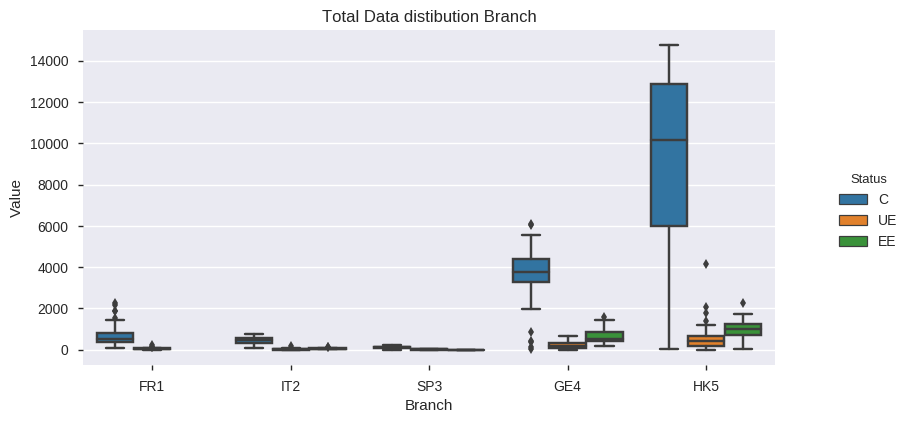

In [26]:
sns.catplot(x="Branch", y="Value", hue="Status", kind="box", data=df)
plt.gcf().set_size_inches(10,4)
#plt.ylabel('')
plt.title('Total Data distibution Branch')
plt.savefig("./output/02Total_Data_distibution_Branch.png")


- We can see that HK5 has the sample with the larger values.   FR1, IT2 and SP3 look really small when compared to it.
#### Distribution by Status

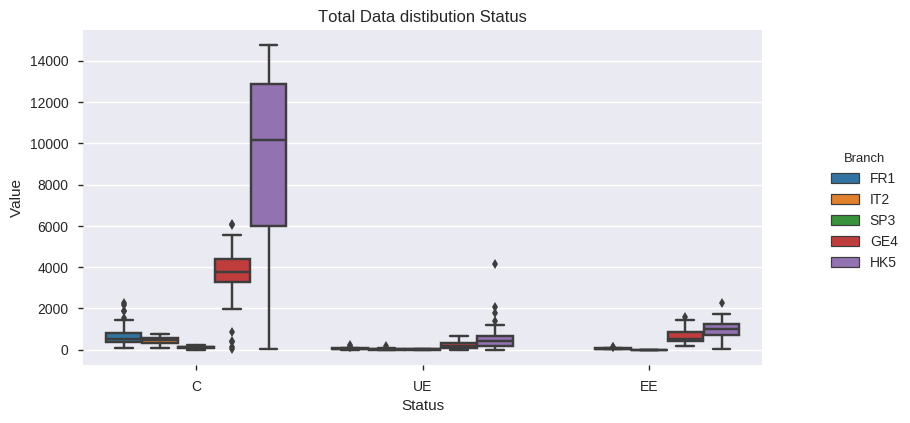

In [27]:
sns.catplot(x="Status", y="Value", hue="Branch", kind="box", data=df)
plt.gcf().set_size_inches(10,4)
#plt.ylabel('')
plt.title('Total Data distibution Status')
plt.savefig("./output/03Total_Data_distibution_Status.png")


- We can see that HK5 has the sample with extreme values for Status = C.      For Status UE again HK5 is the main driver and has clear outliers.    

#### Quantile distribution

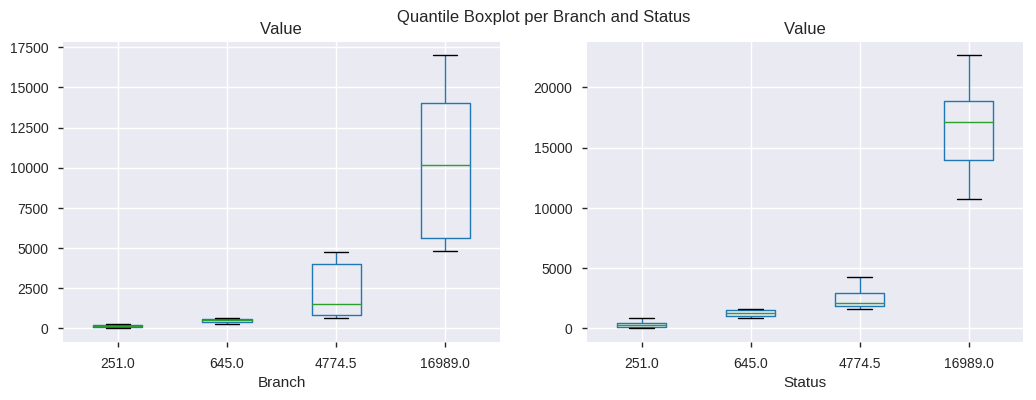

In [28]:
# Quantile distribution
fig, axs = plt.subplots(1, 2, figsize=(12,4))
x = dfBranch.copy(deep=True)
breaks = np.asarray(np.percentile(x.Value, [25,50,75,100]))
x['Branch'] = (x.Value.values > breaks[..., np.newaxis]).sum(0)
x.boxplot(column='Value', by='Branch', ax=axs[0])
axs[0].xaxis.set_ticklabels(['%s'%val for val in breaks]);

x1 = dfStatus.copy(deep=True)
breaksx1 = np.asarray(np.percentile(x1.Value, [25,50,75,100]))
x1['Status'] = (x1.Value.values > breaksx1[..., np.newaxis]).sum(0)
x1.boxplot(column='Value', by='Status', ax=axs[1])
axs[1].xaxis.set_ticklabels(['%s'%val for val in breaks])
fig.suptitle('Quantile Boxplot per Branch and Status', fontsize=12)
plt.savefig("./output/04Quantile_Boxplot_per_Branch_and_Status.png");


- Branch values are heavily accumlated in the 3rd and 4th quantiles  
- Status values are accumulated in the 4th quantile and 3rd quantile has several outliers

# Test for Normal Distribution of the data

## Methodology:

Building an Empirical Cumulative Distribution Function (**ECDF**) to visualize the distribution of the data and using **scipy.stats.normaltest** test whether the sample differs from a normal distribution.

This function tests the **`null hypothesis that a sample comes from a normal distribution`**. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.

The `p value` shown will validate wheter or not the data is normally distributed.

We can adjust aplha to indicate to which percentage of precision we want to validate the data normallity.  on this case we will use 0.1
meaning if the data is within a 10% of the normal distribution, the data will be considered normally distributed this is the **`Null hypothesis`**.

If `p value` is greater than alpha we cannot reject the null hypothesis and must conclude the data is normally distributed.

### Testing on the monthly series

(s^2 + k^2): 358.2853737070243	pvalue: 1.582412213227274e-78
p = 1.58241e-78	alplha = 0.100
The null hypothesis can be rejected


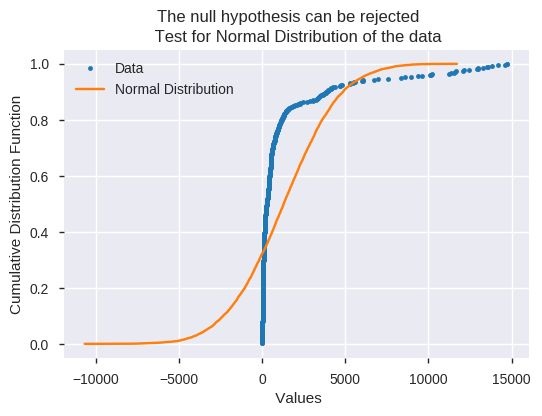

(s^2 + k^2): 47.754208968062564	pvalue: 4.2687947989147863e-11
p = 4.26879e-11	alplha = 0.100
The null hypothesis can be rejected


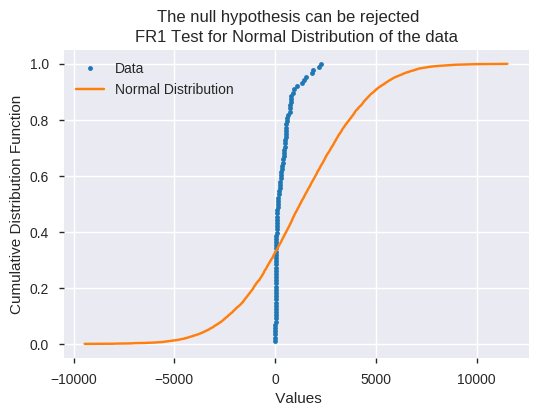

(s^2 + k^2): 15.741421490720878	pvalue: 0.0003817629295207696
p = 0.000381763	alplha = 0.100
The null hypothesis can be rejected


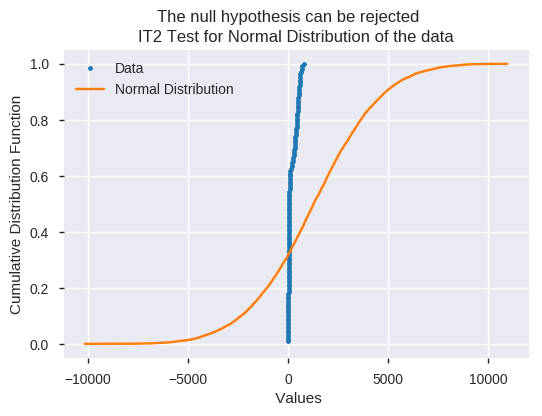

(s^2 + k^2): 10.672361239506003	pvalue: 0.0048142229890101515
p = 0.00481422	alplha = 0.100
The null hypothesis can be rejected


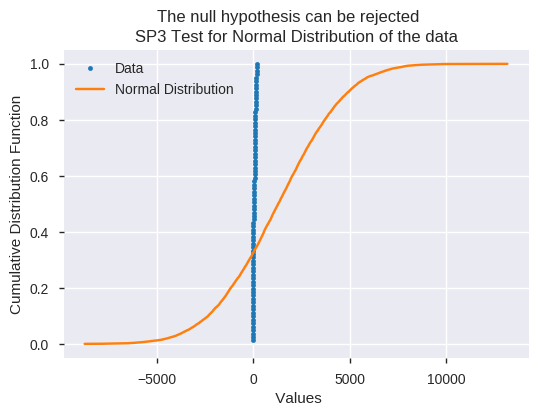

(s^2 + k^2): 17.49566986827648	pvalue: 0.00015880477598388283
p = 0.000158805	alplha = 0.100
The null hypothesis can be rejected


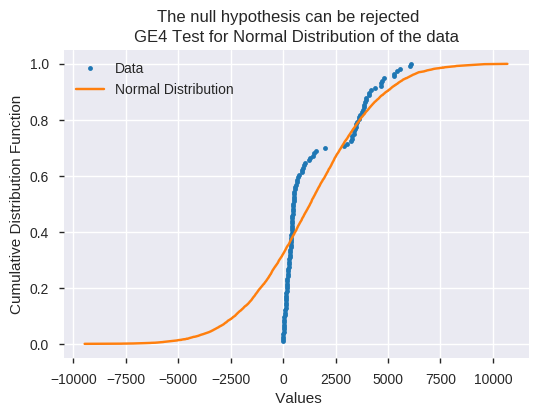

(s^2 + k^2): 23.92121707051891	pvalue: 6.391072039992402e-06
p = 6.39107e-06	alplha = 0.100
The null hypothesis can be rejected


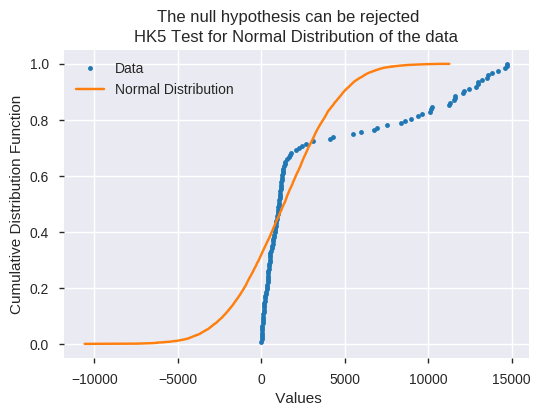

In [29]:
# define a function that will generate plottable points:
def ecdf(data):
    """
    Compute ECDF for a one-dimensional array of measurements.
    This function takes a list of sample readings (temperatures in this example) and sorts them from lowest to highest. 
    It returns a set of (x,y) pairs that represent the temperature reading and the relative position in the sorted list, or percentile, of each reading.
    """
    n = len(data)    # Number of data points: n
    x = np.sort(data)    # x-data for the ECDF: x
    y = np.arange(1, n+1) / n    # y-data for the ECDF: y
    return x, y

# Test all branches for Monthly normally distributed data 

for i in listdfM:
    x, y = ecdf(dictdf[i]["Value"])

    # generate 10,000 'samples' that follow a normal distribution using the mean and the standard deviation of our dataset to scale the range.
    samples = np.random.normal(np.mean(df["Value"]), np.std(df["Value"]), size=10000)

    # Transform the randomized data into x,y to allow us to plot the data alongside the actual samples
    x_theor, y_theor = ecdf(samples)

    # chart

    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker=".", linestyle="none")
    plt.xlabel(" Values")
    plt.ylabel("Cumulative Distribution Function");

    plt.plot(x_theor, y_theor)
    plt.legend(('Data', 'Normal Distribution'), loc='best')
    plt.title("{} Test for Normal Distribution of the data".format(i[2:5]))

    k2, p = stats.normaltest(dictdf[i]["Value"])
    print("(s^2 + k^2): {}\tpvalue: {}".format(k2, p))

    # define alpha as per your criteria
    alpha = 0.1
    print("p = {:g}\talplha = {:0.3f}".format(p, alpha))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
        plt.suptitle('The null hypothesis can be rejected')
    else:
        print("The null hypothesis cannot be rejected")
        plt.suptitle('The null hypothesis cannot be rejected')

    plt.savefig("./output/05Test_for_Normal_Distribution_of_the_data_" + i[2:5] + ".png");

    plt.show()


### Testing on the summary series (Status values consolidated per branch and the total data)

(s^2 + k^2): 5.961616636167258	pvalue: 0.05075179368775998
p = 0.0507518	alplha = 0.100
The null hypothesis can be rejected


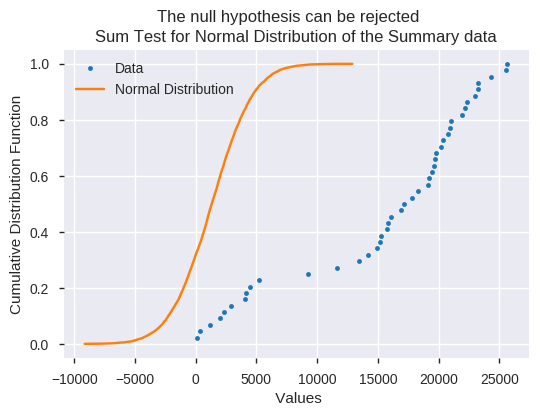

(s^2 + k^2): 18.1632000184431	pvalue: 0.00011373947757791924
p = 0.000113739	alplha = 0.100
The null hypothesis can be rejected


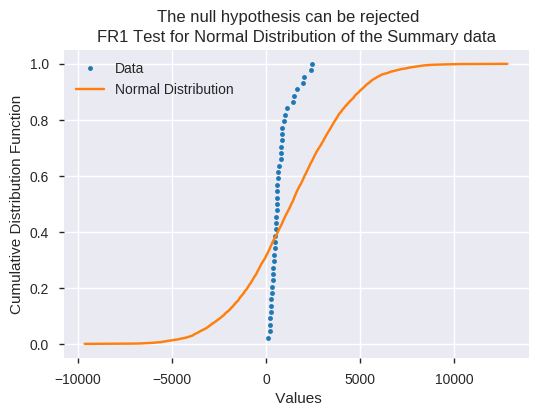

(s^2 + k^2): 1.2700405560167773	pvalue: 0.5299247423902442
p = 0.529925	alplha = 0.100
The null hypothesis cannot be rejected


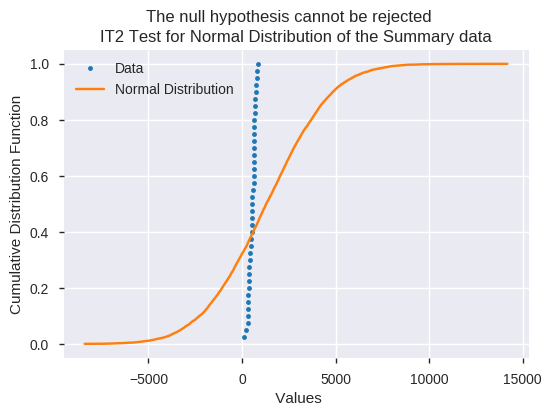

(s^2 + k^2): 0.032095922139047654	pvalue: 0.984080121388326
p = 0.98408	alplha = 0.100
The null hypothesis cannot be rejected


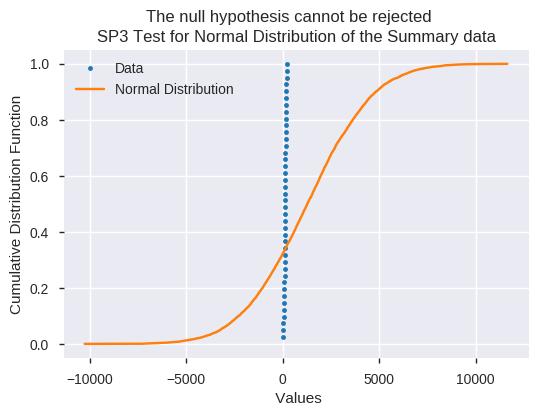

(s^2 + k^2): 12.092873679947456	pvalue: 0.0023662784317696325
p = 0.00236628	alplha = 0.100
The null hypothesis can be rejected


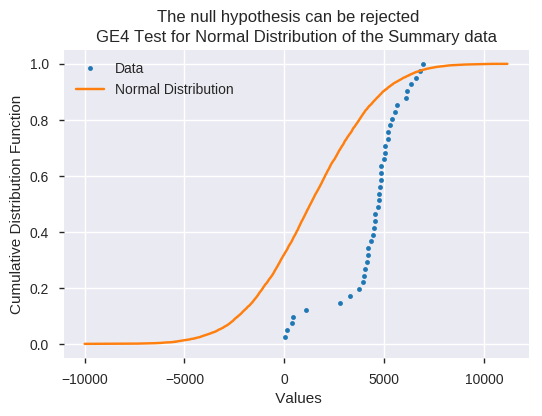

(s^2 + k^2): 5.103102139692429	pvalue: 0.07796064976005972
p = 0.0779606	alplha = 0.100
The null hypothesis can be rejected


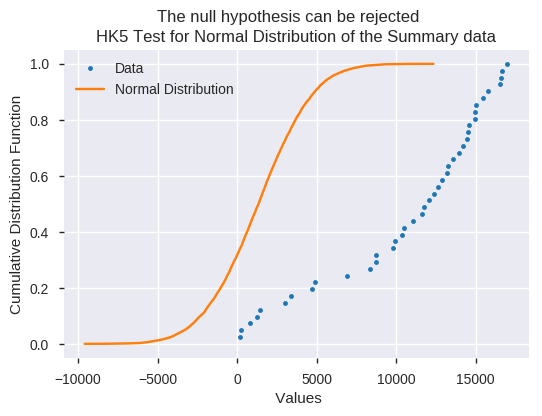

In [30]:
# define a function that will generate plottable points:
def ecdf(data):
    """
    Compute ECDF for a one-dimensional array of measurements.
    This function takes a list of sample readings (temperatures in this example) and sorts them from lowest to highest. 
    It returns a set of (x,y) pairs that represent the temperature reading and the relative position in the sorted list, or percentile, of each reading.
    """
    n = len(data)    # Number of data points: 
    x = np.sort(data)    # x-data for the ECDF: x
    y = np.arange(1, n+1) / n    # y-data for the ECDF: y
    return x, y

# Test all branches for Summary normally distributed data 

for i in listdfS:
    x, y = ecdf(dictdf[i]["Value"])

    # generate 10,000 'samples' that follow a normal distribution using the mean and the standard deviation of our dataset to scale the range.
    samples = np.random.normal(np.mean(df["Value"]), np.std(df["Value"]), size=10000)

    # Transform the randomized data into x,y to allow us to plot the data alongside the actual samples
    x_theor, y_theor = ecdf(samples)

    # chart

    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker=".", linestyle="none")
    plt.xlabel(" Values")
    plt.ylabel("Cumulative Distribution Function");

    plt.plot(x_theor, y_theor)
    plt.legend(('Data', 'Normal Distribution'), loc='best')
    plt.title("{} Test for Normal Distribution of the Summary data".format(i[2:5]))

    k2, p = stats.normaltest(dictdf[i]["Value"])
    print("(s^2 + k^2): {}\tpvalue: {}".format(k2, p))

    # define alpha as per your criteria
    alpha = 0.1
    print("p = {:g}\talplha = {:0.3f}".format(p, alpha))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
        plt.suptitle('The null hypothesis can be rejected')
    else:
        print("The null hypothesis cannot be rejected")
        plt.suptitle('The null hypothesis cannot be rejected')

    plt.savefig("./output/05Test_for_Normal_Distribution_of_the_Summary_data_" + i[2:5] + ".png");

    plt.show()


- as the test result indicates, "The null hypothesis can be rejected" we conclude the data is not normally distributed.
- Similar methodology was applied to all the branch in both the Monthly and consolidated data.  results shown on the charts indicate that none of them is normally distribuited within a 10% margin (10% is a big range but can be adjusted as needed) 

## Descriptive Statistics

Total Data distibution :



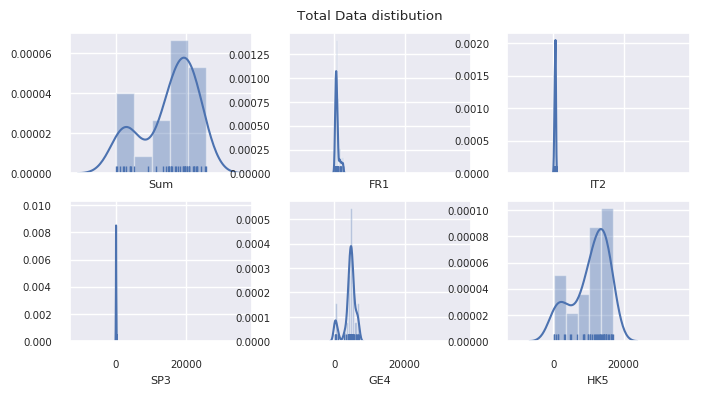

In [31]:
print('Total Data distibution {}:\r\n'.format(''))
#sns.distplot(dictdf['dfSumm'])
#sns.distplot(dictdf['dfSumm'].set_index('date'))
sns.set()
sns.set(font_scale=0.67)

rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(8,4), sharex=True, sharey=False)
fig.suptitle("Total Data distibution", y = 0.94)
#for i in range(rows * cols):
i = 0
for j in range(rows):
    for k in range(cols):
        sns.distplot(dictdf[listdfS[i]].set_index('date'), kde=True, rug=True, ax=axs[j, k], axlabel=(listdfS[i][2:5]))
        plt.savefig("./output/06Total_Data_distibution.png")
        i += 1

- The continuous line is trying to fit the data to a normal distribution.   We can see in summary (Sum) the data has two dome's comparing this with the HK5, we see similarities between them due to the fact that HK5 has the larger values as previously shown. 

In [0]:
# Functions to calculate the Descriptive Statistics
def lower_mode(sequence):
    try:
        return statistics.mode(sequence)
    except statistics.StatisticsError as e:
        return sorted(sequence)[len(sequence)//2 - 1]

def DescriptiveStats(df, xname):
    #("measures of central location")
    s1 = pd.DataFrame([
    statistics.mean(df.Value),
    statistics.harmonic_mean(df.Value),
    statistics.median(df.Value),
    statistics.median_low(df.Value),
    statistics.median_high(df.Value),
    statistics.median_grouped(df.Value),
    lower_mode(df['Value']),

    #("measures of central location")
    statistics.pstdev(df.Value),
    statistics.pvariance(df.Value),
    statistics.stdev(df.Value),
    statistics.variance(df.Value)])
    s1.index = ["Arithmetic mean ('average') of data", "Harmonic mean of data",
                    "Median (middle value) of data", "Low median of data",
                    "High median of data", "Median, or 50th percentile, of grouped data", 
                    "Mode (most common value) of discrete data", "Population standard deviation of data", 
                    "Population variance of data", "Sample standard deviation of data",
                    "Sample variance of data"]

    s1.index.name = 'Description'
    s1.columns = [xname]
    return s1

### Descriptive Statistics Monthly Series
These are the values after aggregating the data per Branch. (but Status are NOT aggregated).   
The Sum represents the total for all branches (status not consolidated)

In [33]:
descriptiveStatsdfM = pd.DataFrame()
s1 = ""
for i in listdfM:
    x = DescriptiveStats(dictdf[i], i[2:])
    descriptiveStatsdfM = pd.concat([descriptiveStatsdfM, x], axis=1, sort=False)

print('Descriptive Statistics Monthly Series\r\n')
# to keep the precision of the df and not converting it to str for printing only
with io.StringIO() as buf, redirect_stdout(buf):
    print(descriptiveStatsdfM.to_string(formatters={
        i : '{:0.1f}'.format for i in descriptiveStatsdfM.columns}))
    s1 = buf.getvalue()
descriptiveStatsdfM.style.format('{0:,.2f}')


Descriptive Statistics Monthly Series



,,FR1,IT2,SP3,GE4,HK5
Description,,,,,,
Arithmetic mean ('average') of data,"1,301.71",377.70,199.53,63.52,"1,538.17","3,513.99"
Harmonic mean of data,29.59,57.24,15.72,11.18,94.55,207.83
Median (middle value) of data,273.00,158.00,69.00,29.00,491.00,"1,054.00"
Low median of data,273.00,153.00,69.00,29.00,484.00,"1,054.00"
High median of data,273.00,163.00,69.00,29.00,498.00,"1,054.00"
"Median, or 50th percentile, of grouped data",273.00,162.50,69.00,29.25,497.50,"1,054.00"
Mode (most common value) of discrete data,5.00,153.00,63.00,5.00,484.00,"1,042.00"
Population standard deviation of data,"2,809.44",499.63,221.52,62.09,"1,780.01","4,712.93"
Population variance of data,"7,892,967.42","249,634.96","49,072.70","3,855.06","3,168,420.14","22,211,708.97"


In [34]:
describedfM = pd.DataFrame()

for i in listdfM:
    x = dictdf[i].describe()
    x.columns=[i[2:]]
    describedfM = pd.concat([describedfM, x], axis=1, sort=False)

print('Descriptive Statistics Monthly Series\r\n')
describedfM.columns = ['Total', 'FR1', 'IT2', 'SP3', 'GE4', 'HK5']
describedfM.style.format('{0:,.2f}')


Descriptive Statistics Monthly Series



,Total,FR1,IT2,SP3,GE4,HK5
count,515.00,88.00,107.00,81.00,116.00,123.00
mean,"1,301.71",377.70,199.53,63.52,"1,538.17","3,513.99"
std,"2,812.17",502.50,222.57,62.48,"1,787.73","4,732.21"
min,1.00,5.00,1.00,1.00,3.00,6.00
25%,49.00,41.00,35.00,7.00,242.00,420.00
50%,273.00,158.00,69.00,29.00,491.00,"1,054.00"
75%,831.00,529.75,385.00,111.00,"3,369.25","5,755.50"
max,"14,748.00","2,270.00",779.00,221.00,"6,087.00","14,748.00"


#### Descriptive Statistics Summary
These are the values after aggregating the data per Branch. (all kind of Status grouped by Branch).   
The Sum represents the monthly aggregation (all branches and all status consolidated)

In [35]:
descriptiveStatsdfS = pd.DataFrame()
s1 = ""
for i in listdfS:
    x = DescriptiveStats(dictdf[i], i[2:5])
    descriptiveStatsdfS = pd.concat([descriptiveStatsdfS, x], axis=1, sort=False)

print('Descriptive Statistics Summary\r\n')
# to keep the precision of the df and not converting it to str for printing only
with io.StringIO() as buf, redirect_stdout(buf):
    print(descriptiveStatsdfS.to_string(formatters={
        i : '{:0.1f}'.format for i in descriptiveStatsdfS.columns}))
    s1 = buf.getvalue()
descriptiveStatsdfS.style.format('{0:,.2f}')


Descriptive Statistics Summary



,Sum,FR1,IT2,SP3,GE4,HK5
Description,,,,,,
Arithmetic mean ('average') of data,"15,235.95",755.41,533.75,125.49,"4,351.90","10,541.98"
Harmonic mean of data,"2,216.91",456.29,455.20,75.02,906.16,"2,451.52"
Median (middle value) of data,"17,506.00",567.00,530.50,115.00,"4,720.00","12,075.00"
Low median of data,"17,192.00",562.00,522.00,115.00,"4,720.00","12,075.00"
High median of data,"17,820.00",572.00,539.00,115.00,"4,720.00","12,075.00"
"Median, or 50th percentile, of grouped data","17,819.50",571.50,538.50,115.00,"4,720.00","12,075.00"
Mode (most common value) of discrete data,"17,192.00",527.00,517.00,113.00,"4,701.00","11,763.00"
Population standard deviation of data,"7,644.59",568.72,170.86,50.54,"1,710.66","5,067.44"
Population variance of data,"58,439,782.63","323,443.24","29,192.94","2,554.30","2,926,368.19","25,678,911.44"


In [36]:
describedfS = pd.DataFrame()

for i in listdfS:
    x = dictdf[i].describe()
    x.columns=[i[2:5]]
    describedfS = pd.concat([describedfS, x], axis=1, sort=False)

print('Descriptive Statistics Summary Series\r\n')
# to keep the precision of the df and not converting it to str for printing only
describedfS.style.format('{0:,.2f}')


Descriptive Statistics Summary Series



,Sum,FR1,IT2,SP3,GE4,HK5
count,44.00,44.00,40.00,41.00,41.00,41.00
mean,"15,235.95",755.41,533.75,125.49,"4,351.90","10,541.98"
std,"7,732.97",575.30,173.04,51.17,"1,731.91","5,130.39"
min,85.00,85.00,122.00,6.00,42.00,174.00
25%,"11,027.50",370.75,389.50,100.00,"4,031.00","8,341.00"
50%,"17,506.00",567.00,530.50,115.00,"4,720.00","12,075.00"
75%,"20,823.50",855.75,648.75,161.00,"5,215.00","14,519.00"
max,"25,668.00","2,423.00",856.00,233.00,"6,931.00","16,989.00"


In [37]:
df.iloc[:, 0:4].pivot_table(index='date', columns=['Status', 'Branch'], values='Value', aggfunc='sum', margins=True).describe().astype('int32')

Status      C                               ...    UE                       All
Branch    FR1     GE4     HK5    IT2   SP3  ...   GE4    HK5   IT2  SP3        
count      45      42      42     41    42  ...    42     42    39   39      45
mean     1375    7024   17574    895   223  ...   385   1194    78   23   29794
std      4540   22255   55744   2800   707  ...  1226   3845   240   71   97962
min        70      27      35     88     5  ...     3      6     1    3      85
25%       354    3312    6180    347    92  ...    71    190     7    5   11616
50%       532    3788   10189    466   111  ...   184    420    36    9   17820
75%       802    4594   12952    565   151  ...   312    770    60   19   20957
max     30950  147511  369068  18365  4688  ...  8090  25091  1527  454  670382

[8 rows x 15 columns]

In [38]:
df.iloc[:, 0:4].pivot_table(index='date', columns=['Branch', 'Status'], values='Value', aggfunc='sum', margins=True).describe().astype('int32')

Branch    FR1           GE4               ...   IT2   SP3             All
Status      C    UE       C     EE    UE  ...    UE     C EE   UE        
count      45    45      42     35    42  ...    39    42  3   39      45
mean     1375   101    7024   1304   385  ...    78   223  2   23   29794
std      4540   335   22255   3762  1226  ...   240   707  1   71   97962
min        70     5      27    181     3  ...     1     5  1    3      85
25%       354    30    3312    427    71  ...     7    92  1    5   11616
50%       532    41    3788    536   184  ...    36   111  2    9   17820
75%       802    60    4594    943   312  ...    60   151  2   19   20957
max     30950  2288  147511  22827  8090  ...  1527  4688  3  454  670382

[8 rows x 15 columns]

## Graphical ditribution and corelation of the data
To close on the tasks
- to determine the type of data and how is its broken down
- identify if the data is normally distributed
The charts below help us see how the data is categorized and its correlation.  

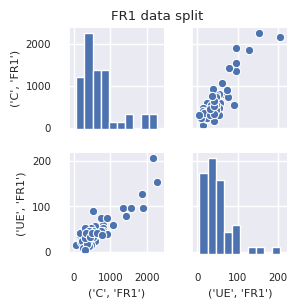

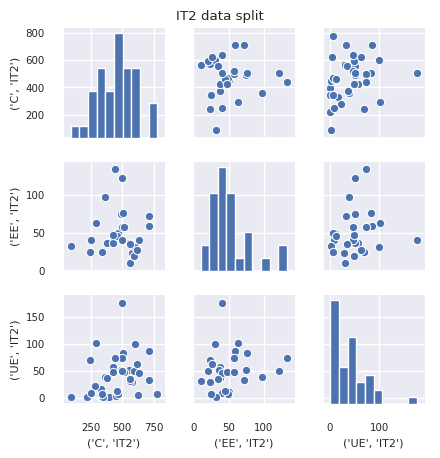

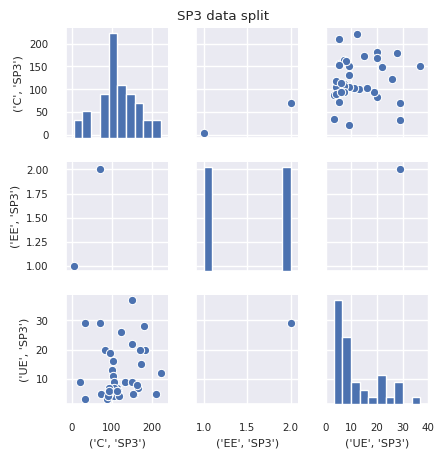

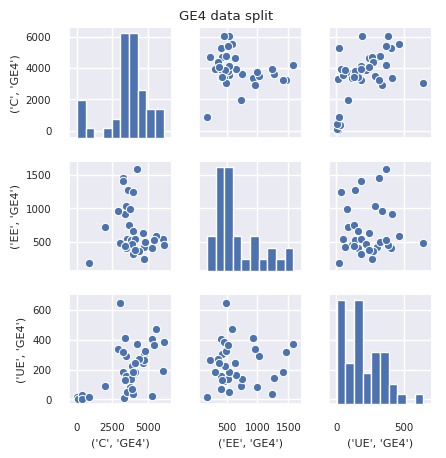

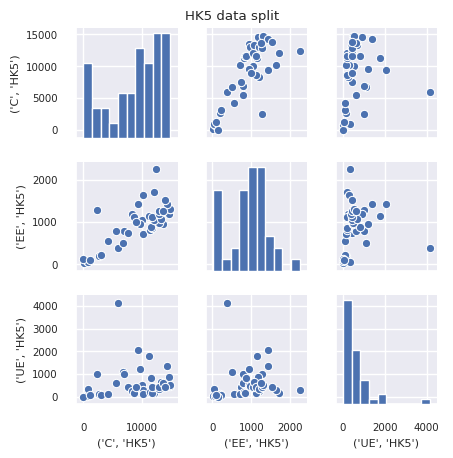

In [39]:
sns.set()
sns.set(font_scale=0.67)

for i in listdfM[1:]:
    dfi = dictdf[i].pivot_table(index='date', columns=['Status', 'Branch'], values='Value', aggfunc='sum')
    sns_plot = sns.pairplot(dfi, height=1.5)
    sns_plot.fig.suptitle("{} data split".format(i[2:]), y=1.001) # y= some height>1
    sns_plot.savefig("./output/07data_split" + i[2:] + ".png")



***
***


## Forecasting

This is the final task, Using different methods to forecast and draw the results for each one.   
- non-seasonal methods (Exponential Smoothing)
    - SES (Simple Exponential Smoothing)
    - Holt's
    - Exponential
    - Additive Damped
    - Multiplicative Damped<br>
<br>
- Seasonal methods
    - Additive
    - Multiplicative
    - Additive Damped
    - Multiplicative Damped<br>

As this is a forecast, there is no data to validate against; but, in scenarios where a larger dataset (daily data for two or more years for instance) is available, a subset of the data can be used to forecast (called `Training set` in Machine Learning lingo) and validate the model using the remaining data (`Validation set`) in that way it will be possible to measure the level of accurracy of the different models and determine which one best fits the data provided. (Identify which model has learned better compared to the reallity)

A `Training set` can be 10% of random samples of the data and it's recommended to be no lesser than 50 samples.   The information currently availablefor this task is monthly and has only 44 months of information (44 consolidated entries in total) and since the data is quite disperse (as shown in the previous sections) the 10% sample data will be 5 records and usign them to forecast is not the recommended approach.

So, for this particular case Machine Learning will not be used, rather differnet forecast models will be presented and when more data becomes avilable it can be used to run the models again and determine which one predicted the most fitted results.



# Exponential smoothing

The heavy lifthing was done in the previosus section, at this point we have the data ready for us to apply the different models. 

## Simple Exponential Smoothing

In [0]:
df = pd.read_csv('./tmp/dfSumm.csv', header=0, parse_dates=True, index_col='date')
df.index = df.index.to_period('M') # This is the trick to set the frequency.... and prevent the below code from failing
df.index.name = '' # Need to remove the "date" from the index name.   The code below takes the 'index name' as the first date and fails
df = df.iloc[1:-1] # removing first and last values
data = df['Value'].astype('double') # needed to avoid ValueError: Buffer dtype mismatch, expected 'double' but got 'long long'

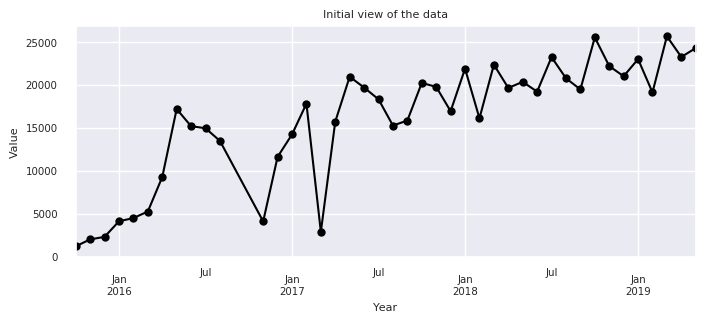

In [41]:
ax = data.plot(marker='o', color='black', figsize=(8,3))
ax.set_xlabel("Year")
ax.set_ylabel("Value")
plt.title("Initial view of the data")
plt.savefig("./output/10Initial.png");
plt.show()
#print("Simple Exponential Smoothing")

Running three variants of simple exponential smoothing:
1. In ```fit1``` we do not use the auto optimization but instead choose to explicitly provide the model with the $\alpha=0.2$ parameter
2. In ```fit2``` as above we choose an $\alpha=0.6$
3. In ```fit3``` we allow statsmodels to automatically find an optimized $\alpha$ value for us. This is the recommended approach.

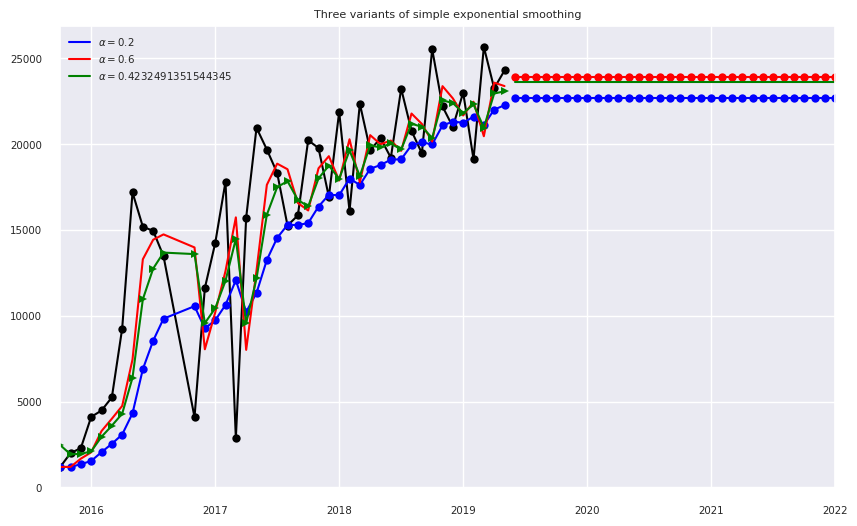

In [42]:
nperiods = 32 # how many periods to forecast

fit1 = SimpleExpSmoothing(data).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(nperiods).rename(r'$\alpha=0.2$')
fit2 = SimpleExpSmoothing(data).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(nperiods).rename(r'$\alpha=0.6$')
fit3 = SimpleExpSmoothing(data).fit()
fcast3 = fit3.forecast(nperiods).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

ax = data.plot(marker='o', color='black', figsize=(10,6))

fcast1.plot(marker='o', ax=ax, color='blue', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='blue')
fcast2.plot(marker='o', ax=ax, color='red', legend=True)
fit2.fittedvalues.plot(marker='x', ax=ax, color='red')
fcast3.plot(marker='x', ax=ax, color='green', legend=True)
fit3.fittedvalues.plot(marker='>', ax=ax, color='green')

plt.title("Three variants of simple exponential smoothing")
plt.savefig("./output/11Three_variants_SME.png");
plt.show()

## Fitting using Holt's Method

1. In ```fit1``` we again choose not to use the optimizer and provide explicit values for $\alpha=0.8$ and $\beta=0.2$
2. In ```fit2``` we do the same as in ```fit1``` but choose to use an exponential model rather than a Holt's additive model.
3. In ```fit3``` we used a damped versions of the Holt's additive model but allow the dampening parameter $\phi$ to be optimized while fixing the values for $\alpha=0.8$ and $\beta=0.2$

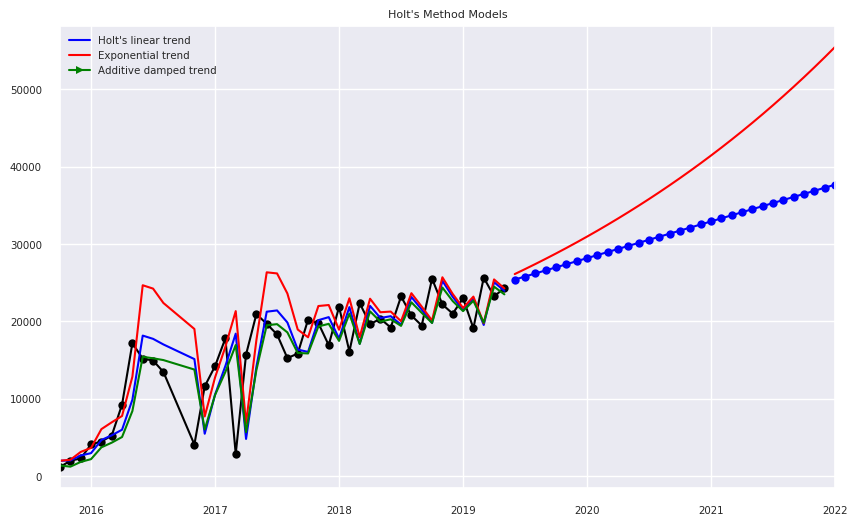

In [43]:
fit1 = Holt(data).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(nperiods).rename("Holt's linear trend")
fit2 = Holt(data, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(nperiods).rename("Exponential trend")
fit3 = Holt(data, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(nperiods).rename("Additive damped trend")

ax = data.plot(color="black", marker="o", figsize=(10,6))

fit1.fittedvalues.plot(ax=ax, color='blue')
fcast1.plot(ax=ax, color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='red', marker="x", legend=True)
fit3.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='green', marker=">", legend=True)

plt.title("Holt's Method Models")
plt.savefig("./output/12Holt_Models.png");
plt.show()

## Seasonally adjusted data
Fitting five Holt's models.   
The below table allows us to compare results when we use exponential versus additive and damped versus non-damped.

Note: ```fit4``` does not allow the parameter $\phi$ to be optimized by providing a fixed value of $\phi=0.98$

In [0]:
fit1 = SimpleExpSmoothing(data).fit()
fit2 = Holt(data).fit()
fit3 = Holt(data,exponential=True).fit()
fit4 = Holt(data,damped=True).fit(damping_slope=0.98)
fit5 = Holt(data,exponential=True,damped=True).fit()
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'initial_level', 'initial_slope']
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$l_0$","$b_0$","SSE"] ,columns=['SES', "Holt's","Exponential", "Additive", "Multiplicative"])
results["SES"] =            [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] =         [fit2.params[p] for p in params] + [fit2.sse]
results["Exponential"] =    [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] =       [fit4.params[p] for p in params] + [fit4.sse]
results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results.to_csv('./output/nonseasonal.csv')

### Parameters generated by the non-seasonal models

In [45]:
pd.read_csv('./output/nonseasonal.csv', index_col=0).style.format('{:,.02f}')

,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,0.42,0.16,0.43,0.00,0.04
$\beta$,nan,0.16,0.43,0.00,0.04
$\phi$,nan,nan,nan,0.98,0.88
$l_0$,"2,470.92","1,196.00","1,738.46","3,445.43","1,596.96"
$b_0$,nan,804.00,2.41,767.09,1.53
SSE,"736,359,512.69","645,065,499.63","1,145,381,360.30","532,454,927.85","550,353,560.90"


The following plots can be used to evaluate the level and slope/trend components of the above table's fits.

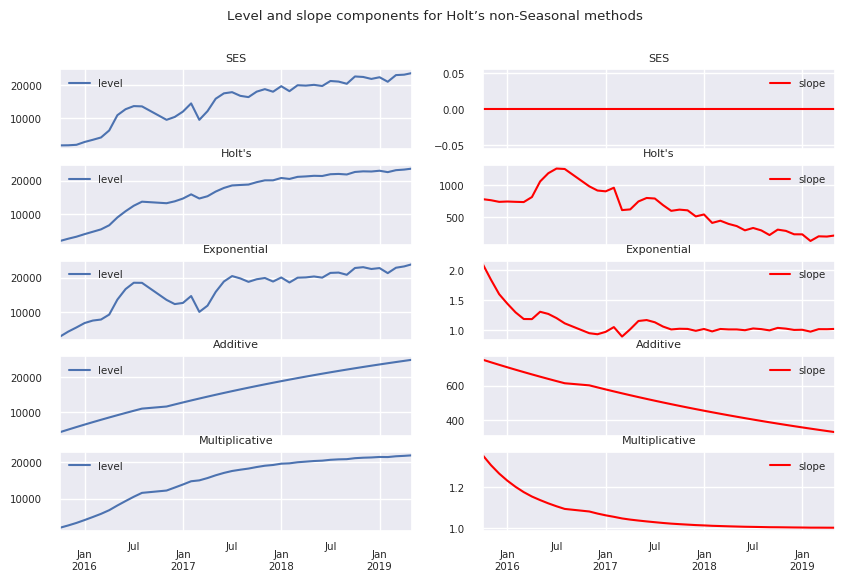

Level and slope components for Holt’s methods


In [46]:
rows, cols = 5, 2
fig, ax2d = plt.subplots(rows, cols, figsize=(10,6), sharex=True, sharey=False, squeeze=False)
fig.suptitle("Seasonally Adjusted Data", y = 0.94)
axli = ax2d.flatten()

i = 0
for fit in [fit1, fit2, fit3, fit4, fit5]:
    x = pd.DataFrame(np.c_[fit.level,fit.slope,fit.season], columns=['level','slope','seasonal'], index=data.index)
    x.iloc[:, 0:1].plot(ax=axli[i], legend=True)
    axli[i].set_title(results.columns[i//cols])
    x.iloc[:, 1:2].plot(ax=axli[i+1], legend=True, color='red')
    axli[i+1].set_title(results.columns[i//cols])
    i += 2

#ax=plt.gca()
plt.suptitle("Level and slope components for Holt’s non-Seasonal methods")
plt.savefig("./output/13Level_slope_Holts_non_Seasonal.png");
plt.show()
print("Level and slope components for Holt’s methods")

note: The seasonal component for the above forecast is zero.

## Comparison
Comparing the Simple Exponential Smoothing and Holt's Methods for various additive, exponential and damped combinations. All of the models parameters will be optimized by statsmodels.

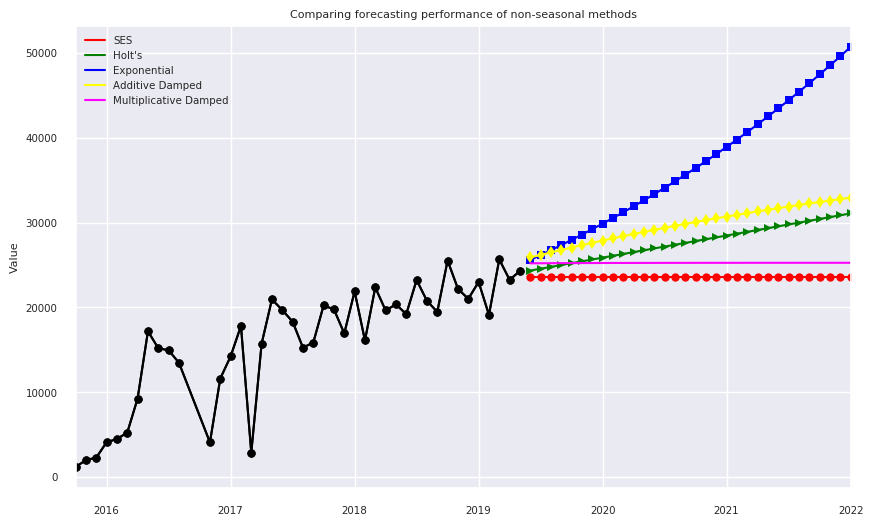

Comparing forecasting performance of non-seasonal methods.


In [47]:
fit1 = SimpleExpSmoothing(data).fit()
fcast1 = fit1.forecast(nperiods).rename("SES")
fit2 = Holt(data).fit()
fcast2 = fit2.forecast(nperiods).rename("Holt's")
fit3 = Holt(data, exponential=True).fit()
fcast3 = fit3.forecast(nperiods).rename("Exponential")
fit4 = Holt(data, damped=True).fit(damping_slope=0.98)
fcast4 = fit4.forecast(nperiods).rename("Additive Damped")
fit5 = Holt(data, exponential=True, damped=True).fit()
fcast5 = fit5.forecast(nperiods).rename("Multiplicative Damped")

ax = data.plot(color="black", marker="o", figsize=(10,6))
data.plot(ax=ax, color="black", marker="o", legend=False)

fcast1.plot(ax=ax, color='red', legend=True, marker="o")
fcast2.plot(ax=ax, color='green', legend=True, marker=">")
fcast3.plot(ax=ax, color='blue', legend=True, marker="s")
fcast4.plot(ax=ax, color='yellow', legend=True, marker="d")
fcast5.plot(ax=ax, color='magenta', legend=True, marker="x")

ax.set_ylabel('Value')
plt.title("Comparing forecasting performance of non-seasonal methods")
plt.savefig("./output/14Comparing_forecasting_performance_non_seasonal.png");
plt.show()
print('Comparing forecasting performance of non-seasonal methods.')

### Plots of Seasonally Adjusted Data

## Holt's Winters Seasonal
Finally we are able to run full Holt's Winters Seasonal Exponential Smoothing  including a trend component and a seasonal component.
statsmodels allows for all the combinations including as shown in the examples below:
1. ```fit1``` additive trend, additive seasonal of period ```season_length=4``` and the use of a Box-Cox transformation.
1. ```fit2``` additive trend, multiplicative seasonal of period ```season_length=4``` and the use of a Box-Cox transformation..
1. ```fit3``` additive damped trend, additive seasonal of period ```season_length=4``` and the use of a Box-Cox transformation.
1. ```fit4``` additive damped trend, multiplicative seasonal of period ```season_length=4``` and the use of a Box-Cox transformation.

The plot shows the results and forecast for ```fit1``` to ```fit4```.
The table allows us to compare the results and parameterizations.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


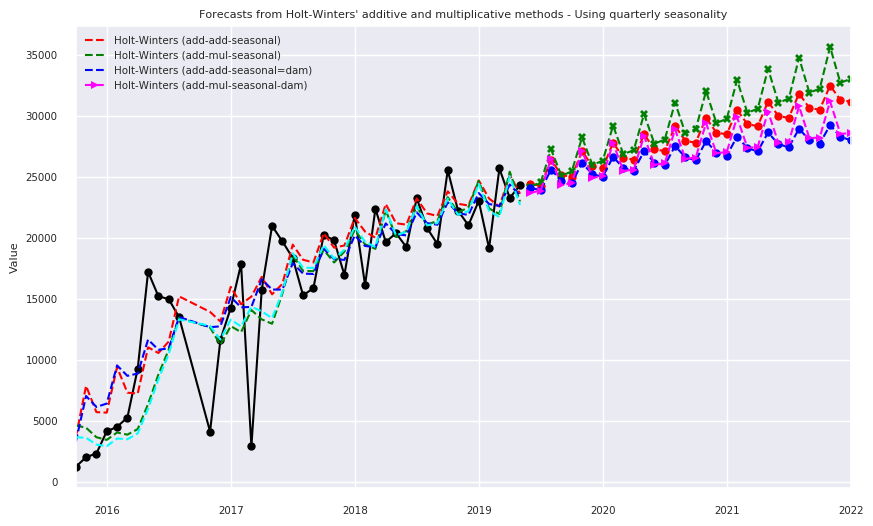

Forecasting using Holt-Winters method with both additive and multiplicative seasonality.


In [48]:
speriods = 3 # Seasonality period 7 for weekly daily data, 12 for yearly seasonality with monthly data
fit1 = ExponentialSmoothing(data, seasonal_periods=speriods, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(data, seasonal_periods=speriods, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(data, seasonal_periods=speriods, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(data, seasonal_periods=speriods, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = data.plot(figsize=(10,6), marker='o', color='black' )
ax.set_ylabel("Value")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')
fit3.fittedvalues.plot(ax=ax, style='--', color='blue')
fit4.fittedvalues.plot(ax=ax, style='--', color='cyan')

fit1.forecast(nperiods).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(nperiods).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='X', color='green', legend=True)
fit3.forecast(nperiods).rename('Holt-Winters (add-add-seasonal=dam)').plot(ax=ax, style='--', marker='o', color='blue', legend=True)
fit4.forecast(nperiods).rename('Holt-Winters (add-mul-seasonal-dam)').plot(ax=ax, style='--', marker='>', color='magenta', legend=True)

plt.title("Forecasts from Holt-Winters' additive and multiplicative methods - Using quarterly seasonality")
plt.savefig("./output/15Forecasting_Holt_Winters__additive_mul_seasonality.png");

plt.show()
print("Forecasting using Holt-Winters method with both additive and multiplicative seasonality.")
results.to_csv('./output/seasonal.csv')

### Parameters generated by the seasonal models

In [49]:
results.style.format('{:,.02f}')

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.12,0.24,0.00,0.21
$\beta$,0.12,0.06,0.00,0.12
$\phi$,nan,nan,0.98,0.98
$\gamma$,0.00,0.00,0.00,0.00
$l_0$,"449,216.24","421,731.25","441,248.06","421,731.25"
$b_0$,"29,454.51","19,245.80","27,483.16","19,245.80"
SSE,"574,053,180.67","634,024,191.79","487,726,609.01","637,054,731.66"


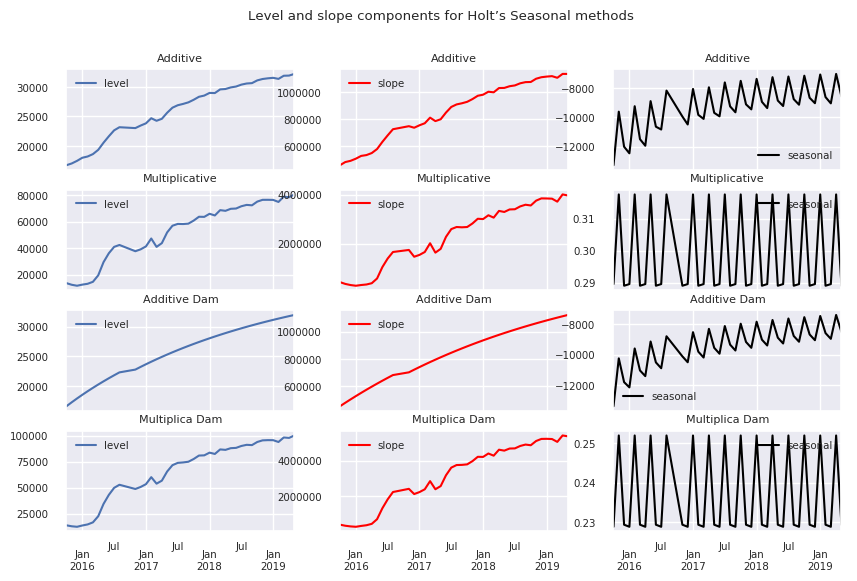

Level and slope components for Holt’s methods


In [50]:
rows, cols = 4, 3
fig, ax2d = plt.subplots(rows, cols, figsize=(10,6), sharex=True, sharey=False, squeeze=False)
fig.suptitle("Seasonally Adjusted Data", y = 0.94)
axli = ax2d.flatten()

i = 0
for fit in [fit1, fit2, fit3, fit4]:
    x = pd.DataFrame(np.c_[fit.level,fit.slope,fit.season], columns=['level','slope','seasonal'], index=data.index)
#    x = pd.DataFrame(np.c_[fit.level,fit.slope,fit.season]).rename(columns={0:'level',1:'slope', 2:'seasonal'}), index=data.index
#    axli[i].plot(x.iloc[:, 0:1])
#    axli[i+1].plot(x.iloc[:, 1:2])
    x.iloc[:, 0:1].plot(ax=axli[i], legend=True)
    axli[i].set_title(results.columns[i//cols])
    x.iloc[:, 1:2].plot(ax=axli[i+1], legend=True, color='red')
    axli[i+1].set_title(results.columns[i//cols])
    x.iloc[:, 2:3].plot(ax=axli[i+2], legend=True, color='black')
    axli[i+2].set_title(results.columns[i//cols])
    i += 3

#ax=plt.gca()
plt.suptitle("Level and slope components for Holt’s Seasonal methods")
plt.savefig("./output/16Exponential_Smoothing_comparision.png");
plt.show()
print("Level and slope components for Holt’s methods")

Looking at the levels, slopes/trends and seasonal components of the models.

### The Internals
Following is a sample of the tables generated during the modeling that show side by side the original values $y_t$, the level $l_t$, the trend $b_t$, the season $s_t$ and the fitted values $\hat{y}_t$.

In [0]:
 pd.options.display.max_rows = 13

In [52]:
df = pd.DataFrame(np.c_[data, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=data.index)
df.append(fit1.forecast(nperiods).rename(r'$\hat{y}_t$').to_frame(), sort=True)

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
2015-10,3589.477202,461948.890574,16721.856746,-13270.154345,1196.0
2015-11,7847.979942,485077.601068,17019.702632,-9607.093815,2000.0
2015-12,5691.492865,494200.547478,17462.311232,-12004.514806,2296.0
2016-01,5648.221406,509993.781473,17990.662187,-12456.066145,4112.0
2016-02,9376.687639,530272.757154,18203.838739,-9235.351755,4485.0
2016-03,7282.602046,536425.845067,18610.311484,-11490.866271,5248.0
...,...,...,...,...,...
2021-08,31810.920485,NaN,NaN,NaN,NaN
2021-09,30624.983147,NaN,NaN,NaN,NaN
2021-10,30489.551163,NaN,NaN,NaN,NaN


In [53]:
df = pd.DataFrame(np.c_[data, fit2.level, fit2.slope, fit2.season, fit2.fittedvalues], 
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=data.index)
df.append(fit2.forecast(nperiods).rename(r'$\hat{y}_t$').to_frame(), sort=True)

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
2015-10,4599.412228,427472.813291,13504.238253,0.289554,1196.0
2015-11,4412.823810,354417.075147,12265.268405,0.317649,2000.0
2015-12,3633.053561,307968.407221,11538.022981,0.289034,2296.0
2016-01,3413.231014,280098.086918,12376.628666,0.289555,4112.0
2016-02,4019.626726,309464.943350,13007.730164,0.317649,4485.0
2016-03,3844.427908,330866.686798,14507.791588,0.289034,5248.0
...,...,...,...,...,...
2021-08,34738.918296,NaN,NaN,NaN,NaN
2021-09,31881.428658,NaN,NaN,NaN,NaN
2021-10,32210.402582,NaN,NaN,NaN,NaN


***
***


## Others...
There are other methods that can be used to forecast, for the purpose of this activity below are some examples    
please note: **`(the charts below are not automatically updated when refreshing this book.   these are here solely to give visibility of other options and a taste of the results)`**

using Facebook Prophet forecasting package as the basis and customizing the final chart.

In [85]:
Image(url='https://github.com/feapri/forecast/master/output/fb1.png')

Forecast prepared with Microsoft Excel using the "Classical Multiplicative Model"

In [88]:
Image(url="https://github.com/feapri/forecast/master/output/excel.png")

![excel](https://drive.google.com/file/d/1iJ82SEHTym6NYXbghCkynCcrYQbXZS6Y/view?usp=sharing)

This is the end of the forecast and the activity